In [1]:
# Install Gradio
!pip install gradio -q

     |████████████████████████████████| 2.9 MB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
     |████████████████████████████████| 2.0 MB 10.4 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 212 kB 45.8 MB/s 
     |████████████████████████████████| 54 kB 1.3 MB/s 
     |████████████████████████████████| 253 kB 43.9 MB/s 
     |████████████████████████████████| 84 kB 2.4 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 271 kB 44.8 MB/s 
     |████████████████████████████████| 144 kB 50.7 MB/s 
     |████████████████████████████████| 10.9 MB 33.2 MB/s 
     |████████████████████████████████| 58 kB 3.5 MB/s 
     |████████████████████████████████| 79 kB 4.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 61 kB 401 kB/s 
     |████████████████████████████████| 856 kB 43.1 MB/s 
     |████████████████████████

In [2]:
# Install timidy
!sudo apt-get install -q -y timidity libsndfile1

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
The following additional packages will be installed:
  freepats libaudio2 timidity-daemon
Suggested packages:
  nas fluid-soundfont-gm fluid-soundfont-gs pmidi
The following NEW packages will be installed:
  freepats libaudio2 timidity timidity-daemon
0 upgraded, 4 newly installed, 0 to remove and 41 not upgraded.
Need to get 29.6 MB of archives.
After this operation, 35.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freepats all 20060219-1 [29.0 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaudio2 amd64 1.9.4-6 [50.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 timidity amd64 2.13.2-41 [585 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 timidity-daemon all 2.13.2-41 [5,984 B]
Fetched 29.6 MB in 3s (11.5 MB/s)
debconf: unable

In [3]:
# All the imports to deal with sound data
!pip install pydub numba==0.48 librosa music21

     |████████████████████████████████| 3.5 MB 4.0 MB/s 
     |████████████████████████████████| 20.2 MB 1.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [77]:
# Import Libraries

import gradio as gr
import time

import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

#print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

In [7]:
# The audio input file
# Now the hardest part: Record your singing! :)

# We provide four methods to obtain an audio file:

# 1.   Record audio directly in Gradio
# 2.   Use a file saved on Google Drive

In [82]:
# Use a file saved on Google Drive
INPUT_SOURCE = 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav'

In [8]:
!wget --no-check-certificate 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav' -O c-scale.wav

--2022-04-29 15:10:53--  https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.240, 172.217.164.16, 172.217.11.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384728 (376K) [audio/wav]
Saving to: ‘c-scale.wav’

c-scale.wav         100%[===================>] 375.71K  --.-KB/s    in 0.003s  

2022-04-29 15:10:53 (111 MB/s) - ‘c-scale.wav’ saved [384728/384728]



In [9]:
uploaded_file_name = 'c-scale.wav'

In [10]:
uploaded_file_name

'c-scale.wav'

In [11]:
# Function that converts the user-created audio to the format that the model 
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [12]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)

  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, 
                            y_axis='log', 
                            sr=sample_rate, 
                            cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, 
                            y_axis='log', 
                            sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

  return fig

In [ ]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

fig = plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)

In [13]:
# Executing the Model
# Loading the SPICE model is easy:
model = hub.load("https://tfhub.dev/google/spice/2")

In [84]:
def plot_pitch_conf(pitch_outputs,confidence_outputs):
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  plt.plot(pitch_outputs, label='pitch')
  plt.plot(confidence_outputs, label='confidence')
  plt.legend(loc="lower right")
  return fig

In [85]:
def plot_pitch_conf_notes(confident_pitch_outputs_x,confident_pitch_outputs_y):
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  ax.set_ylim([0, 1])
  plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
  plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")
  return fig

In [86]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

In [17]:
def espectro_notas(audio_samples,EXPECTED_SAMPLE_RATE,confident_pitch_outputs_x,confident_pitch_values_hz):
  fig, ax = plt.subplots()
  plot_stft(audio_samples / MAX_ABS_INT16 , 
            sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
  # Note: conveniently, since the plot is in log scale, the pitch outputs 
  # also get converted to the log scale automatically by matplotlib.
  plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")
  return fig

In [87]:
  def hz2offset(freq):
    # This measures the quantization error for a single note.
    if freq == 0:  # Rests always have zero error.
      return None
    # Quantized note.
    h = round(12 * math.log2(freq / C0))
    return 12 * math.log2(freq / C0) - h

In [88]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note

In [89]:
def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests

In [91]:
def main(audio):

  # Preparing the audio data
  # Now  we  have the  audio,  let's  convert it to the expected format and then 
  # listen to it!
  # The SPICE model needs as input an audio file at a sampling rate of 16kHz and
  # with only one channel (mono). 
  # To help you with this part, we created a function(`convert_audio_for_model`) 
  #to convert any wav file you have to the model's expected format:


  # Converting to the expected format for the model
  # in all the input 4 input method before, the uploaded file name is at
  # the variable uploaded_file_name
  converted_audio_file = convert_audio_for_model(audio)

  # Loading audio samples from the wav file:
  sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

  audio_samples = audio_samples / float(MAX_ABS_INT16)


  # We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
  model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

  pitch_outputs = model_output["pitch"]
  uncertainty_outputs = model_output["uncertainty"]

  # 'Uncertainty' basically means the inverse of confidence.
  confidence_outputs = 1.0 - uncertainty_outputs
 

  confidence_outputs = list(confidence_outputs)
  pitch_outputs = [ float(x) for x in pitch_outputs]

  indices = range(len (pitch_outputs))
  confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
  confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

  confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]
  

  #Plot waves
  fig1 = plt.figure()
  plt.plot(audio_samples)

  #Plot 
  fig2 = plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)

  #Plot Pitch & Confidence
  fig3 = plot_pitch_conf(pitch_outputs,confidence_outputs)

  
  #Plot Pitch & Confidence Notes
  fig4 = plot_pitch_conf_notes(confident_pitch_outputs_x,confident_pitch_outputs_y)

  #Plot Espectro + Notes
  fig5 = espectro_notas(audio_samples,EXPECTED_SAMPLE_RATE,confident_pitch_outputs_x,confident_pitch_values_hz)


  # ############################################################################
  # Converting to musical notes ################################################

  # Now that we have the pitch values, let's convert them to notes!
  # This  is  part  is  challenging  by itself. We have to take into account two 
  # things:
  #   1. the rests (when there's no singing) 
  #   2. the size of each note (offsets) 

  # ----------------------------------------------------------------------------
  ### 1: Adding zeros to the output to indicate when there's no singing

  pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
  ]

  # ----------------------------------------------------------------------------
  ### 2: Adding note offsets
  # When  a person  sings freely,  the melody may have an offset to the absolute 
  # pitch values that notes can represent.
  # Hence, to  convert  predictions  to  notes,  one  needs  to correct for this 
  # possible offset.
  # This is what the following code computes.

  A4 = 440
  C0 = A4 * pow(2, -4.75)
  note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

  def hz2offset(freq):
    # This measures the quantization error for a single note.
    if freq == 0:  # Rests always have zero error.
      return None
    # Quantized note.
    h = round(12 * math.log2(freq / C0))
    return 12 * math.log2(freq / C0) - h


  # The ideal offset is the mean quantization error for all the notes
  # (excluding rests):
  offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
  #print("offsets: ", offsets)
  off = offsets

  ideal_offset = statistics.mean(offsets)
  #print("ideal offset: ", ideal_offset)
  ideal_off  = ideal_offset

  # We can now use some heuristics to try and estimate the most likely  sequence 
  # of notes that were sung.
  # The ideal offset computed above is one ingredient - but we also need to know 
  # the speed (how many predictions make, say, an eighth?), and the time  offset 
  # to start quantizing.  To keep it simple, we'll just try different speeds and 
  # time offsets and measure the quantization error, using in the end the values 
  # that minimize this error.

  def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
    non_zero_values = [v for v in group if v != 0]
    zero_values_count = len(group) - len(non_zero_values)

    # Create a rest if 80% is silent, otherwise create a note.
    if zero_values_count > 0.8 * len(group):
      # Interpret as a rest. Count each dropped note as an error, weighted a bit
      # worse than a badly sung note (which would 'cost' 0.5).
      return 0.51 * len(non_zero_values), "Rest"
    else:
      # Interpret as note, estimating as mean of non-rest predictions.
      h = round(
          statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
          ]))
      octave = h // 12
      n = h % 12
      note = note_names[n] + str(octave)
      # Quantization error is the total difference from the quantized note.
      error = sum([
          abs(12 * math.log2(freq / C0) - ideal_offset - h)
          for freq in non_zero_values
      ])
    return error, note


  def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                                 prediction_start_offset, ideal_offset):
    # Apply the start offset - we can just add the offset as rests.
    pitch_outputs_and_rests = [0] * prediction_start_offset + \
                              pitch_outputs_and_rests
    # Collect the predictions for each note (or rest).
    groups = [
        pitch_outputs_and_rests[i:i + predictions_per_eighth]
        for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
    ]

    quantization_error = 0

    notes_and_rests = []
    for group in groups:
      error, note_or_rest = quantize_predictions(group, ideal_offset)
      quantization_error += error
      notes_and_rests.append(note_or_rest)

    return quantization_error, notes_and_rests


  best_error = float("inf")
  best_notes_and_rests = None
  best_predictions_per_note = None

  for predictions_per_note in range(20, 65, 1):
    for prediction_start_offset in range(predictions_per_note):

      error, notes_and_rests = get_quantization_and_error(
          pitch_outputs_and_rests, predictions_per_note,
          prediction_start_offset, ideal_offset)

      if error < best_error:      
        best_error = error
        best_notes_and_rests = notes_and_rests
        best_predictions_per_note = predictions_per_note

  # At this point, best_notes_and_rests contains the best quantization.
  # Since we don't need to have rests at the beginning, let's remove these:
  while best_notes_and_rests[0] == 'Rest':
    best_notes_and_rests = best_notes_and_rests[1:]
  # Also remove silence at the end.
  while best_notes_and_rests[-1] == 'Rest':
    best_notes_and_rests = best_notes_and_rests[:-1]
  
  # ____________________________________________________________________________
  # Now let's write the quantized notes as sheet music score!
  # To do it we will use two libraries: [music21](http://web.mit.edu/music21/) and 
  # [Open Sheet Music Display](https://github.com/opensheetmusicdisplay/opensheetmusicdisplay)
  # **Note:** for simplicity, we assume here that all notes have the same duration 
  # (a half note).

  # Creating the sheet music score.
  sc = music21.stream.Score()
  # Adjust the speed to match the actual singing.
  bpm = 60 * 60 / best_predictions_per_note
  #print ('bpm: ', bpm)
  a = music21.tempo.MetronomeMark(number=bpm)
  sc.insert(0,a)

  for snote in best_notes_and_rests:   
      d = 'half'
      if snote == 'Rest':      
        sc.append(music21.note.Rest(type=d))
      else:
        sc.append(music21.note.Note(snote, type=d))


  # @title [Run this] Helper  function to use Open Sheet Music Display (JS code) 
  # to show a music score
  from IPython.core.display import display, HTML, Javascript
  import json, random

  def showScore(score):
      xml = open(score.write('musicxml')).read()
      showMusicXML(xml)
    
  def showMusicXML(xml):
      DIV_ID = "OSMD_div"
      a = display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
      script = """
      var div_id = {{DIV_ID}};
      function loadOSMD() { 
          return new Promise(function(resolve, reject){
              if (window.opensheetmusicdisplay) {
                  return resolve(window.opensheetmusicdisplay)
              }
              // OSMD script has a 'define' call which conflicts with requirejs
              var _define = window.define // save the define object 
              window.define = undefined // now the loaded script will ignore requirejs
              var s = document.createElement( 'script' );
              s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
              //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
              s.onload=function(){
                  window.define = _define
                  resolve(opensheetmusicdisplay);
              };
              document.body.appendChild( s ); // browser will try to load the new script tag
          }) 
      }
      loadOSMD().then((OSMD)=>{
          window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
            drawingParameters: "compacttight"
          });
          openSheetMusicDisplay
              .load({{data}})
              .then(
                function() {
                  openSheetMusicDisplay.render();
                }
              );
      })
      """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
      #display(Javascript(script))
      return a

  # rendering the music score
  partitura = showScore(sc)
  #print(best_notes_and_rests)



  # ____________________________________________________________________________
  # Let's convert the music notes to a MIDI file and listen to it.
  # To create this file, we can use the stream we created before.

  # Saving the recognized musical notes as a MIDI file
  converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
  fp = sc.write('midi', fp=converted_audio_file_as_midi)

  wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
  #print(wav_from_created_midi)

  # To listen to it on colab, we need to convert it back to wav. An easy way  of 
  # doing that is using Timidity.

  !timidity $converted_audio_file_as_midi -Ow -o $wav_from_created_midi

  return converted_audio_file, fig1, fig2, fig3, fig4,fig5, bpm, best_notes_and_rests, partitura, wav_from_created_midi


We want to invite you to become a beta user.
You'll get early access to new and premium features (persistent links, hosting, and more).
If you're interested please email: beta@gradio.app

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
Running on public URL: https://44874.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Playing converted_audio_file.mid
MIDI file: converted_audio_file.mid
Format: 1  Tracks: 1  Divisions: 1024
Sequence: 
Playing time: ~16 seconds
Notes cut: 0
Notes lost totally: 0
Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7fe07a281510>,
 'http://127.0.0.1:7860/',
 'https://44874.gradio.app')

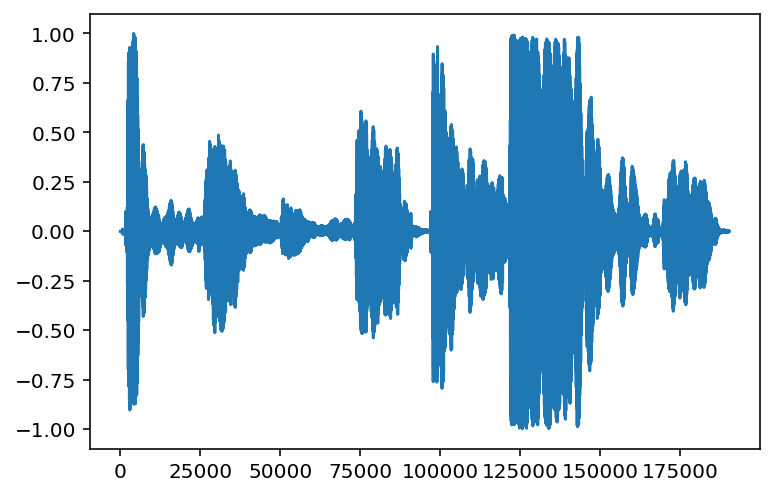

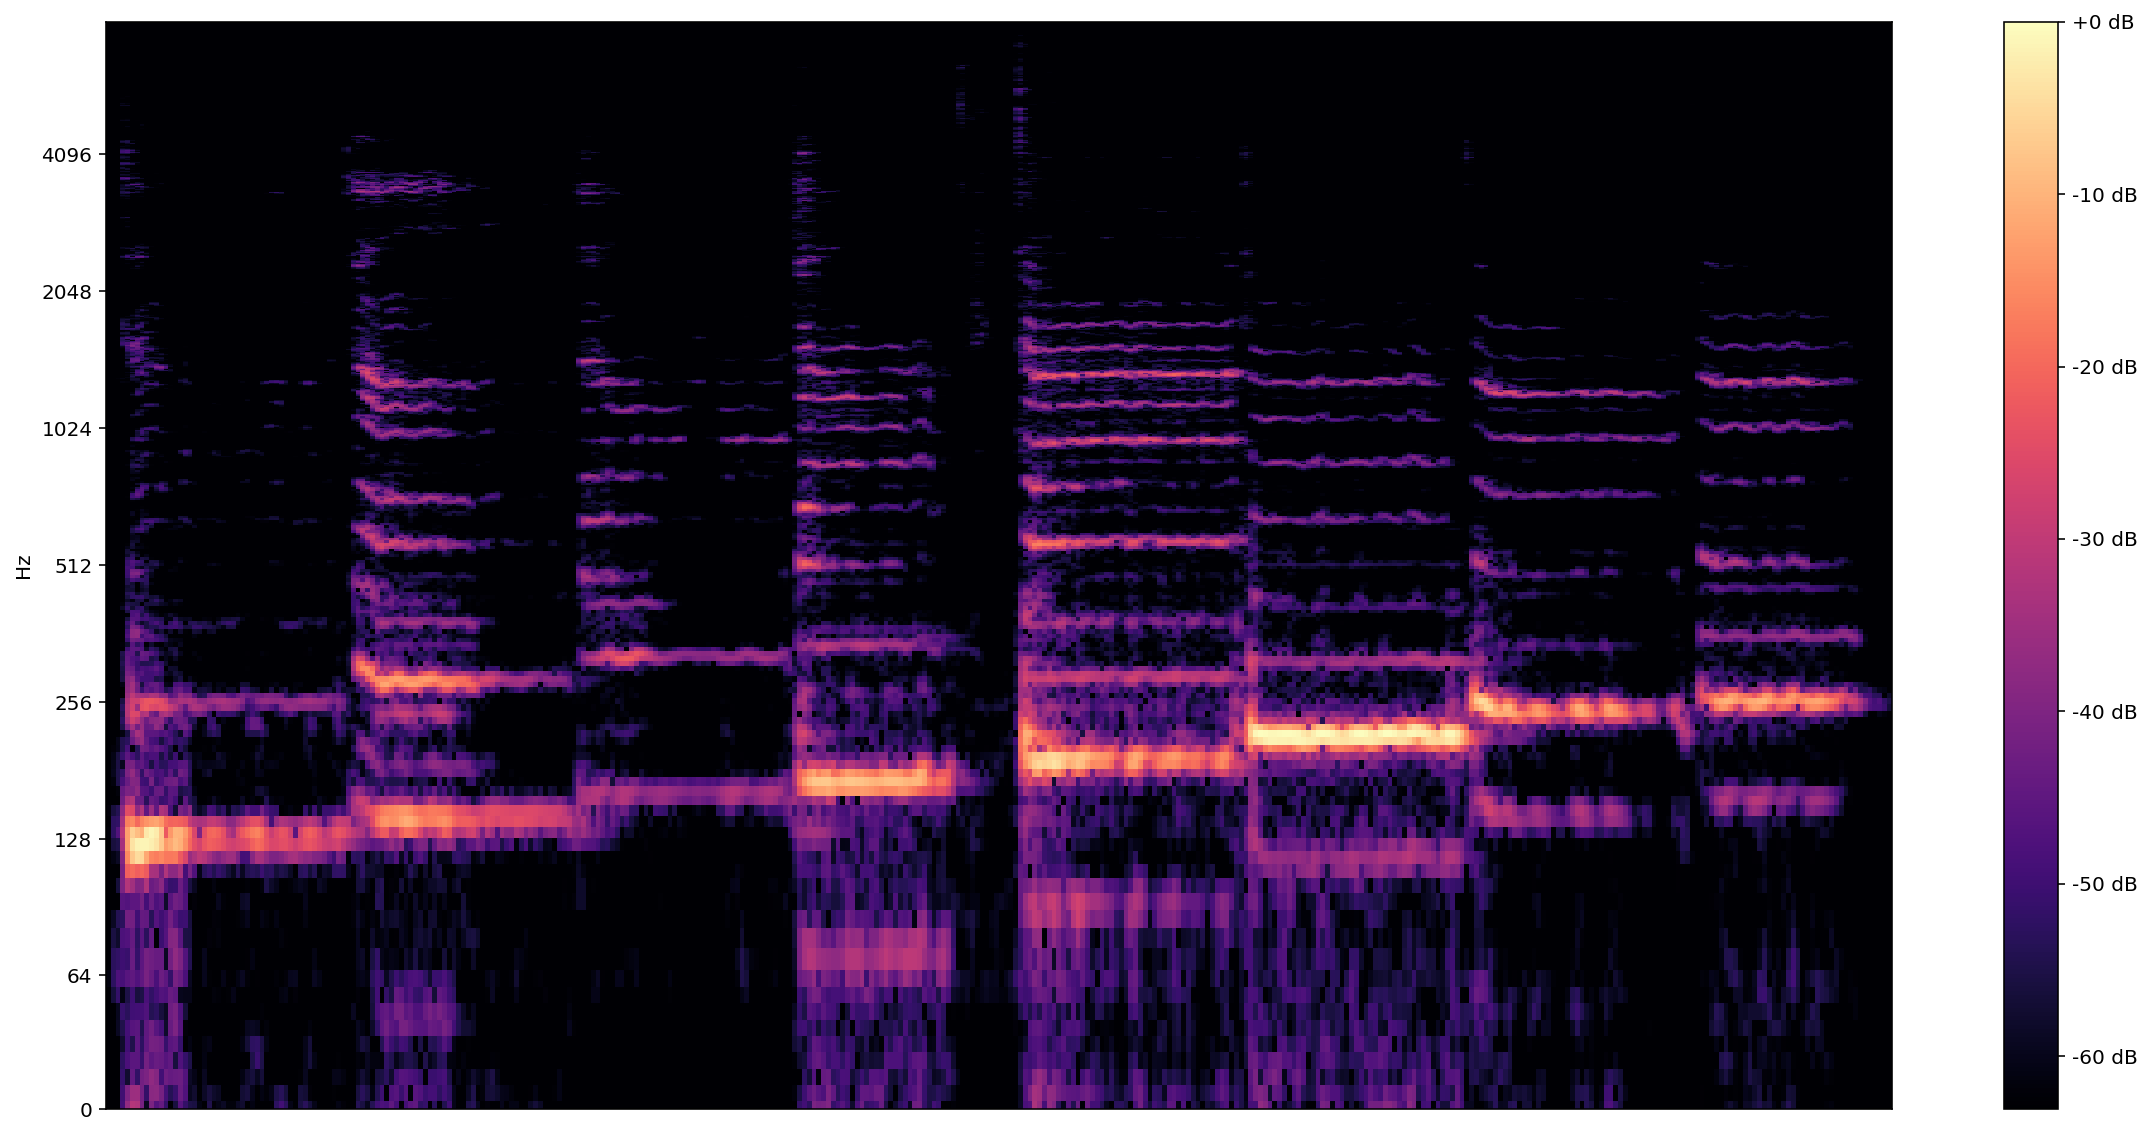

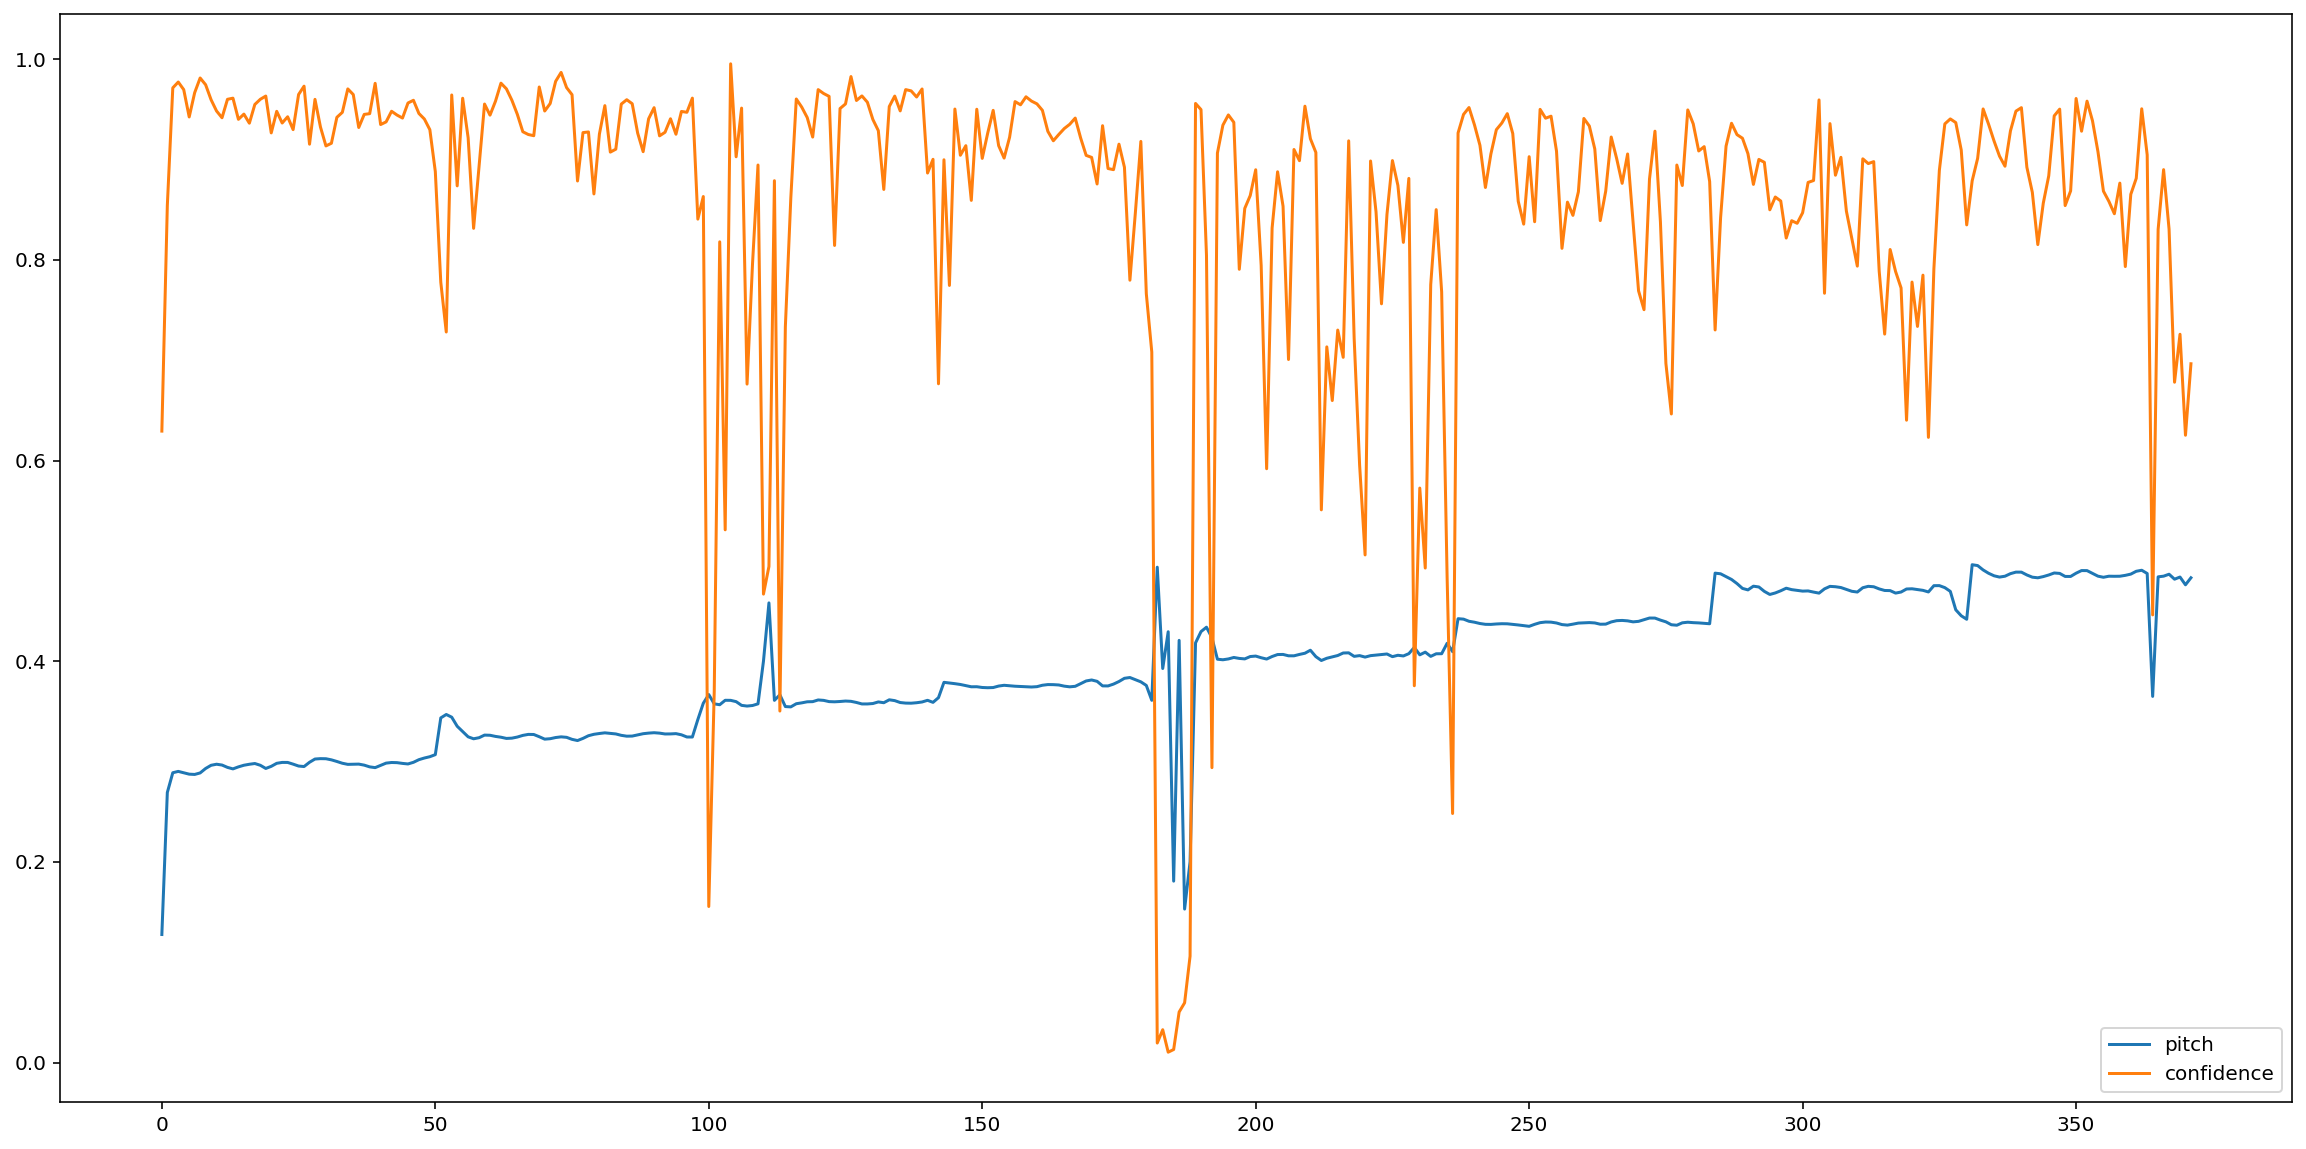

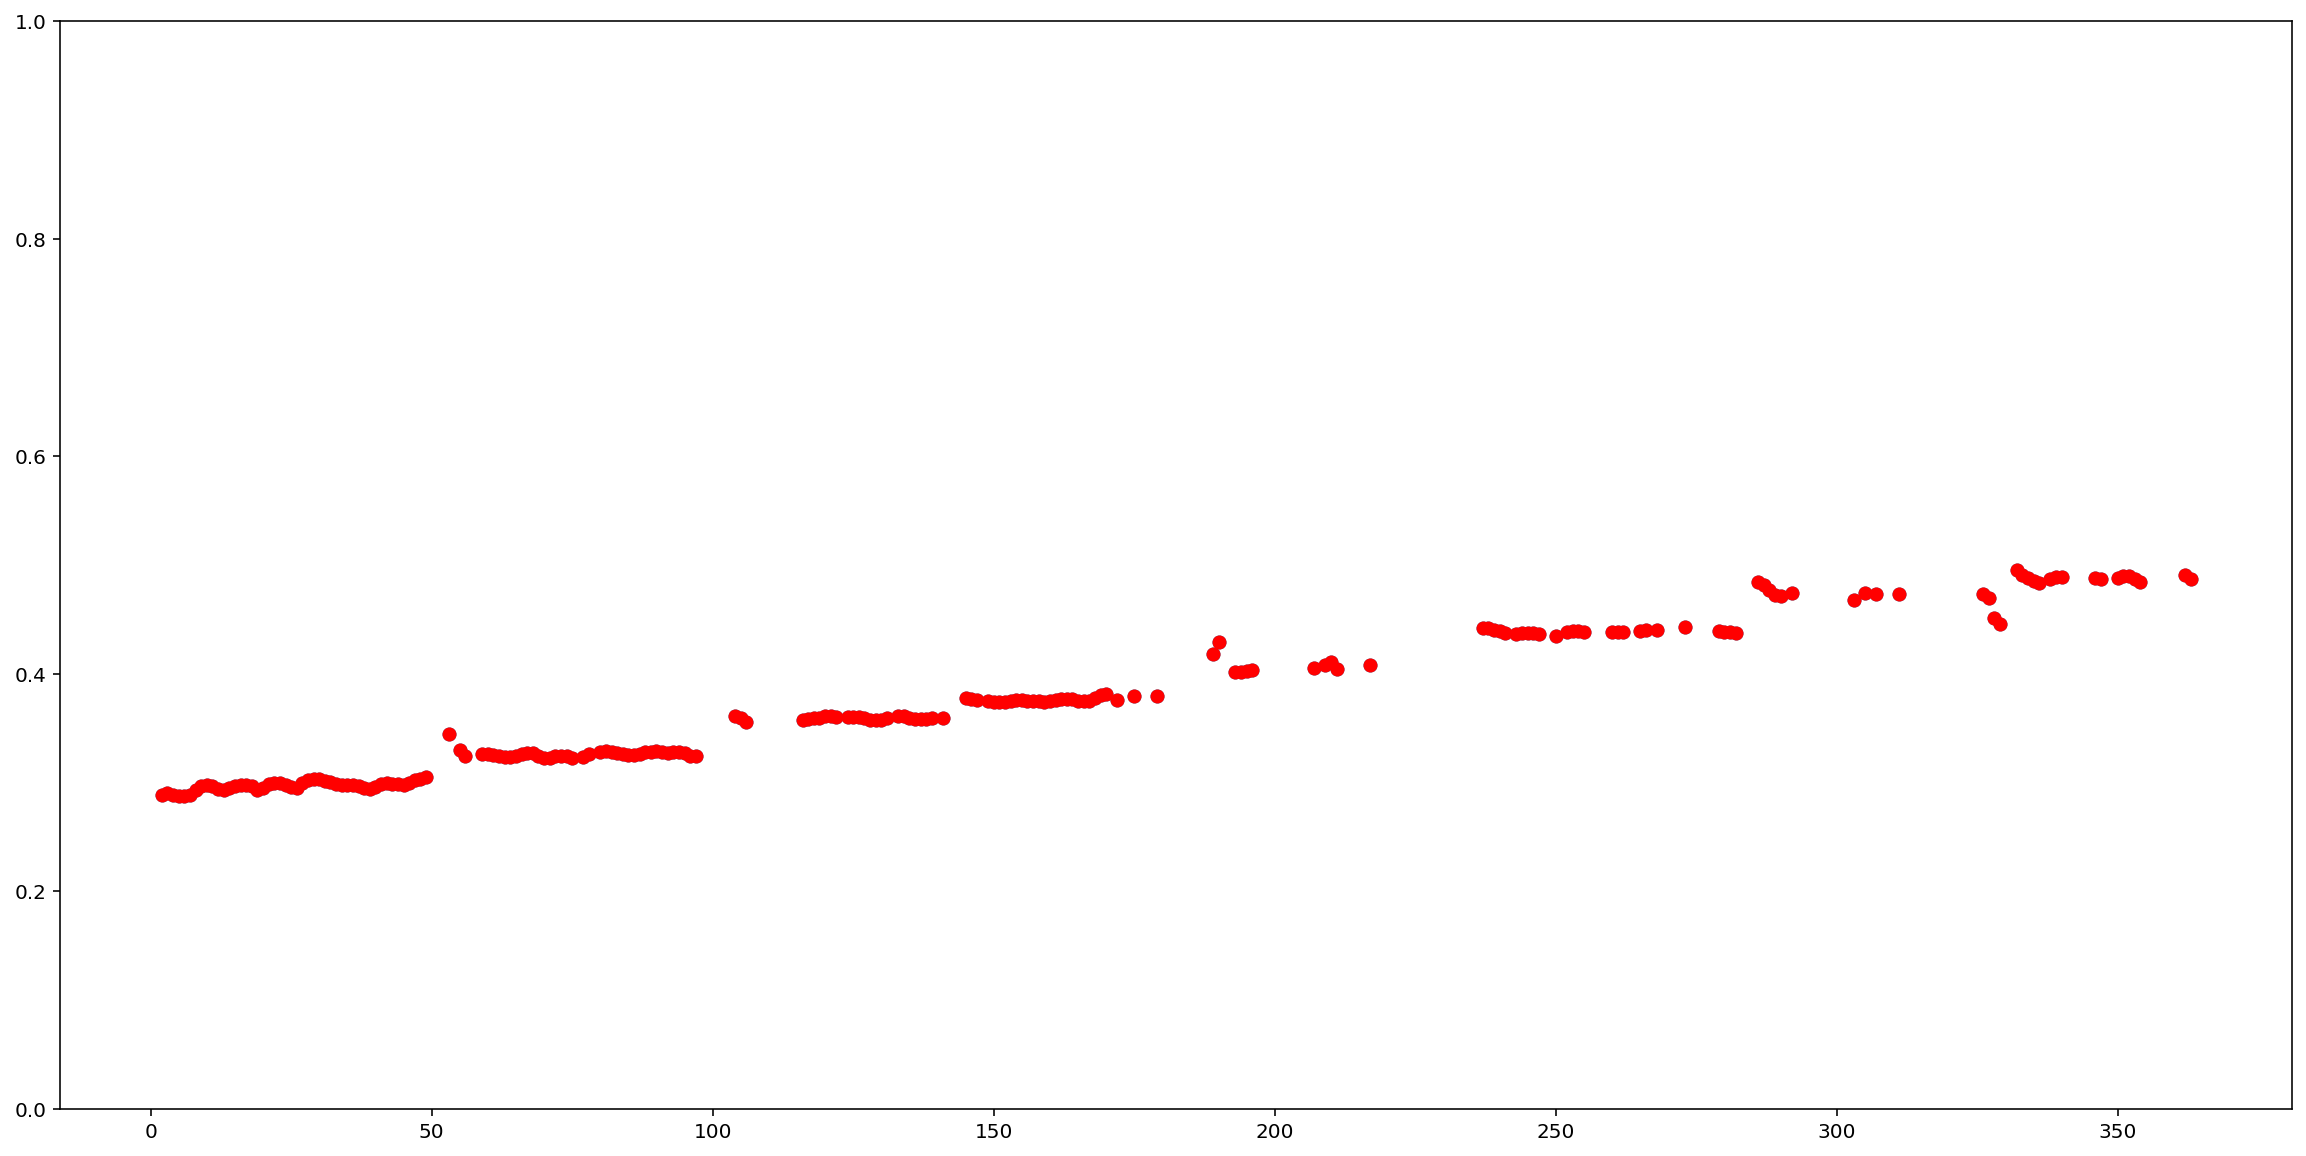

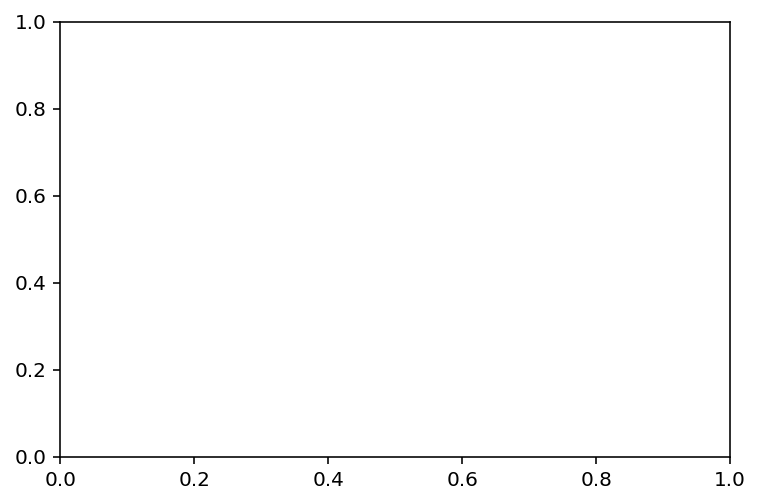

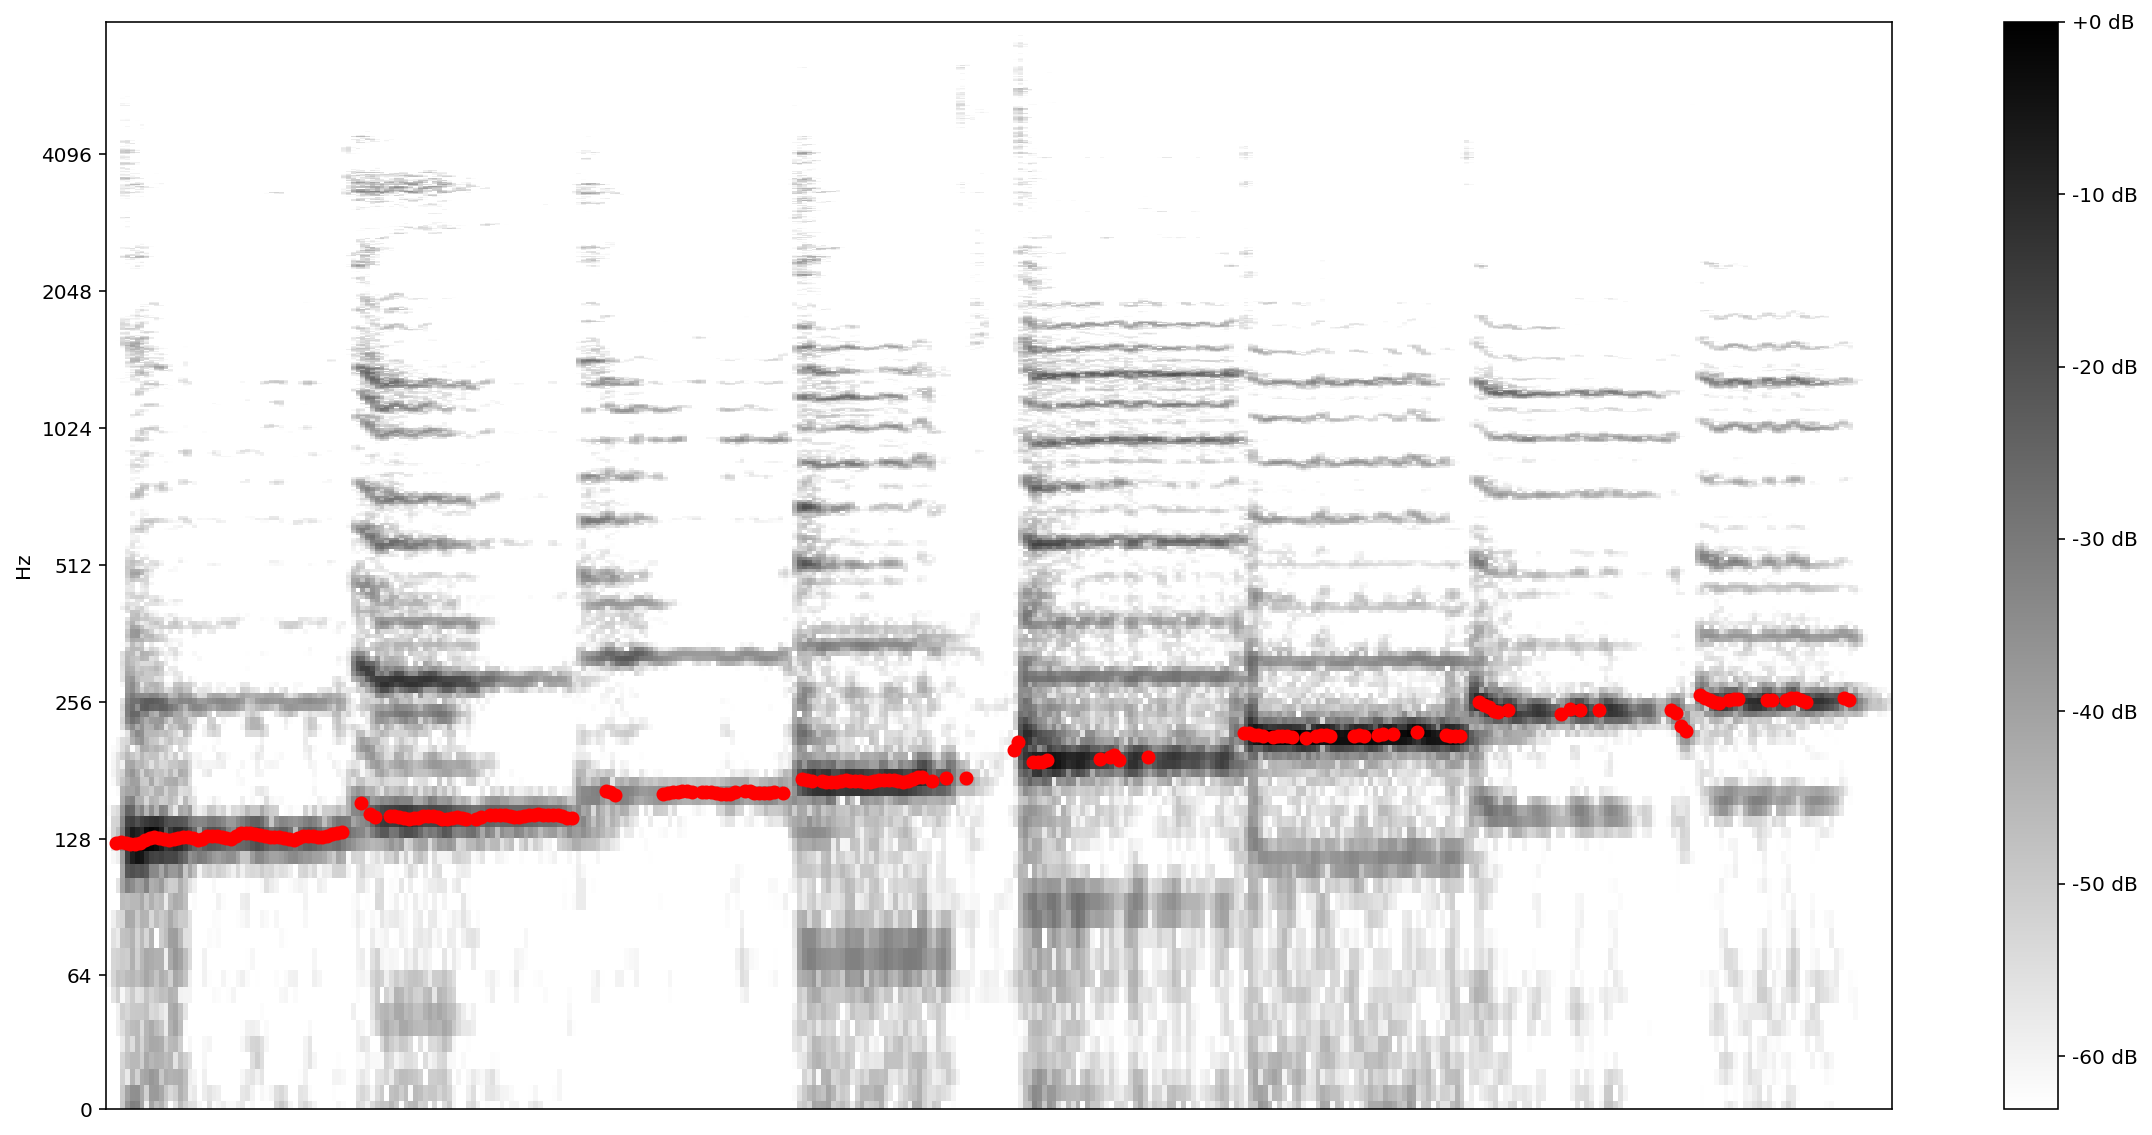

In [92]:
iface = gr.Interface(
    fn=main, 
    inputs = [gr.inputs.Audio(source= "microphone" , type="filepath",label="Ingrese Audio")],
    outputs= [gr.outputs.Audio(label="Audio Original"), 
              gr.outputs.Plot(type="auto",label="Gráfico de Frecuencias"),
              gr.outputs.Plot(type="auto",label="Especto"),
              gr.outputs.Plot(type="auto",label="Pitch Confidence"),
              gr.outputs.Plot(type="auto",label="Notas"),
              gr.outputs.Plot(type="auto",label="Espectro+Notas"),
              gr.outputs.Textbox(label="bpm"),
              gr.outputs.Textbox(label="partitura"),
              gr.outputs.Textbox(type="html",label="partitura1"),
              gr.outputs.Audio(label="midi")],
    examples=[[uploaded_file_name]],
    interpretation = "default",
)

iface.launch(debug=True)